In [ ]:
import tensorflow as tf

In [5]:
def trainModel(X, Y, window_size, n_epochs, learning_rate, n_layers, callback):
    batch_size = 32
    # input dense layer
    input_layer_shape = window_size
    input_layer_neurons = 64
    # LSTM
    rnn_input_layer_features = 16
    rnn_input_layer_timesteps = input_layer_neurons // rnn_input_layer_features
    rnn_input_shape = (rnn_input_layer_features, rnn_input_layer_timesteps) # the shape have to match input layer's shape
    rnn_output_neurons = 16 # number of neurons per LSTM's cell
    # output dense layer
    output_layer_shape = rnn_output_neurons # dense layer input size is same as LSTM cell
    output_layer_neurons = 1 # return 1 value
    # ## old method
    # xs = tf.tensor2d(X, [X.length, X[0].length])//.div(tf.scalar(10));
    # ys = tf.tensor2d(Y, [Y.length, 1]).reshape([Y.length, 1])//.div(tf.scalar(10));
    # ## new: load data into tensor and normalize data
    inputTensor = tf.tensor2d(X, [X.length, X[0].length])
    labelTensor = tf.tensor2d(Y, [Y.length, 1]).reshape([Y.length, 1])
    xs, inputMax, inputMin = normalizeTensorFit(inputTensor)
    ys, labelMax, labelMin = normalizeTensorFit(labelTensor)
    # ## define model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(units=input_layer_neurons, input_shape=[input_layer_shape]))
    model.add(tf.keras.layers.Reshape(target_shape=rnn_input_shape))
    lstm = tf.keras.layers.LSTM(units=rnn_output_neurons)
    model.add(lstm)

    lstm_cells = []
    for i in range(n_layers):
        lstm_cells.append(tf.keras.layers.LSTMCell(units=rnn_output_neurons))

    model.add(tf.keras.layers.RNN(cell=lstm_cells, input_shape=rnn_input_shape, return_sequences=False))
    model.add(tf.keras.layers.Dense(units=output_layer_neurons, input_shape=[output_layer_shape]))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='meanSquaredError')

    hist = model.fit(xs, ys, batchSize=batch_size, epochs=n_epochs, callbacks={'onEpochEnd': lambda epoch, log: callback(epoch, log)})

    return {
        'model': model,
        'stats': hist,
        'normalize': {
            'inputMax': inputMax,
            'inputMin': inputMin,
            'labelMax': labelMax,
            'labelMin': labelMin
        }
    }

In [4]:
def makePredictions(X, model, dict_normalize):
    X = tf.convert_to_tensor(X)
    normalizedInput = normalizeTensor(X, dict_normalize["inputMax"], dict_normalize["inputMin"])
    model_out = model.predict(normalizedInput)
    predictedResults = unNormalizeTensor(model_out, dict_normalize["labelMax"], dict_normalize["labelMin"])
    return list(predictedResults.numpy())

In [3]:
import numpy as np

def normalize_tensor_fit(tensor):
    maxval = np.max(tensor)
    minval = np.min(tensor)
    normalized_tensor = normalize_tensor(tensor, maxval, minval)
    return [normalized_tensor, maxval, minval]

In [1]:
def normalizeTensor(tensor, maxval, minval):
  normalizedTensor = tensor.sub(minval).div(maxval.sub(minval))
  return normalizedTensor

In [2]:
def unNormalizeTensor(tensor, maxval, minval):
    unNormTensor = tensor.mul(maxval.sub(minval)).add(minval)
    return unNormTensor

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
import math
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf

# pip install matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [44]:
config = {
    "y_finance": {
        "period": "10y", # period to download the data from Yahoo Finance
        "symbol": "TSLA", # TSLA - Tesla
        "key_adjusted_close": "adj close",
    },
    "data": {
        "window_size": 50,
        "train_split_size": 0.80,
    }, 
    "plots": {
        "show_plots": True,
        "xticks_interval": 90,
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1, # since we are only using 1 feature, close price
        "num_lstm_layers": 2,
        "lstm_size": 32,
        "dropout": 0.2,
    },
    "training": {
        "device": "cpu", # "cuda" or "cpu"
        "batch_size": 64,
        "num_epoch": 100,
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    }
}

[*********************100%%**********************]  1 of 1 completed
Number data points: 2516 from 2013-09-06 to 2023-09-05


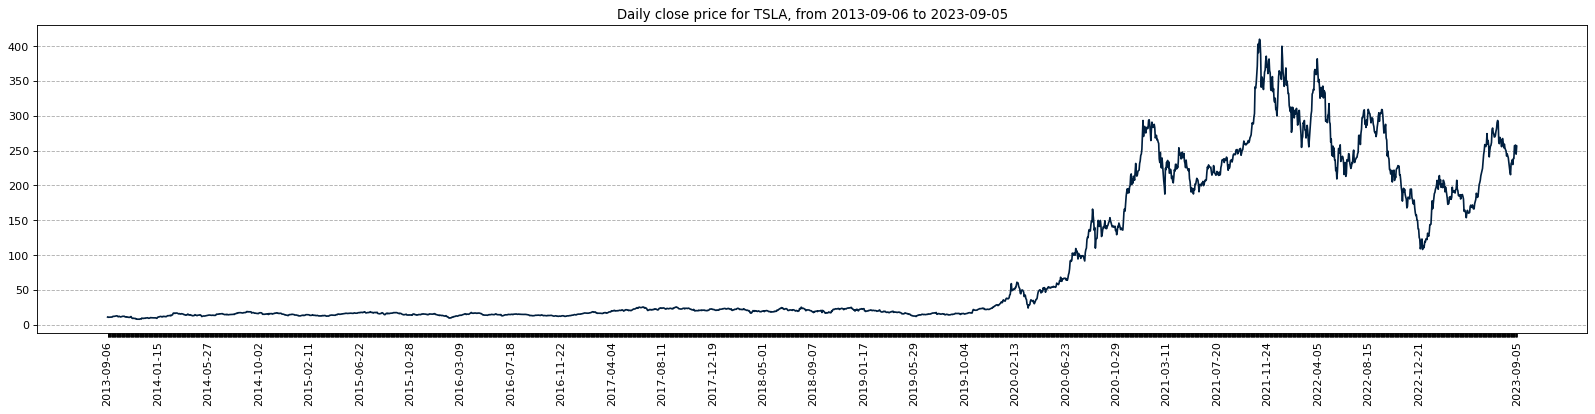

In [45]:
def download_data(config, plot=False):
    # get the data from yahoo finance
    data = yf.download(config["y_finance"]["symbol"], period=config["y_finance"]["period"])

    # Change column names to lower case to process easier
    
    data.columns = data.columns.str.lower()

    # Get the date of data points into a list
    data_date = data.index.strftime('%Y-%m-%d').tolist()

    # Get the adjusted price in each data points 
    data_close_price = data[config["y_finance"]["key_adjusted_close"]]
    data_close_price = np.array(data_close_price)
    
    # Get the number of data points
    num_data_points = len(data_date)

    display_date_range = "from " + data_date[0] + " to " + data_date[num_data_points-1]
    print("Number data points:", num_data_points, display_date_range)

    if plot:
        fig = figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(data_date, data_close_price, color=config["plots"]["color_actual"])
        xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
        x = np.arange(0,len(xticks))
        plt.xticks(x, xticks, rotation='vertical')
        plt.title("Daily close price for " + config["y_finance"]["symbol"] + ", " + display_date_range)
        plt.grid(visible=None, which='major', axis='y', linestyle='--')
        plt.show()

    return data_date, data_close_price, num_data_points, display_date_range

data_date, data_close_price, num_data_points, display_date_range = download_data(config, plot=config["plots"]["show_plots"])

In [46]:
data_close_price

array([ 11.13133335,  10.71333313,  11.09133339, ..., 258.07998657,
       245.00999451, 256.48999023])

In [47]:
from sklearn.preprocessing import MinMaxScaler

# normalize
scaler = MinMaxScaler()
normalized_data_close_price = scaler.fit_transform(data_close_price.reshape(-1, 1))

In [48]:
normalized_data_close_price.shape

(2516, 1)

In [49]:
type(normalized_data_close_price)

numpy.ndarray

In [50]:
normalized_data_close_price = normalized_data_close_price.flatten()

In [51]:
normalized_data_close_price.shape

(2516,)

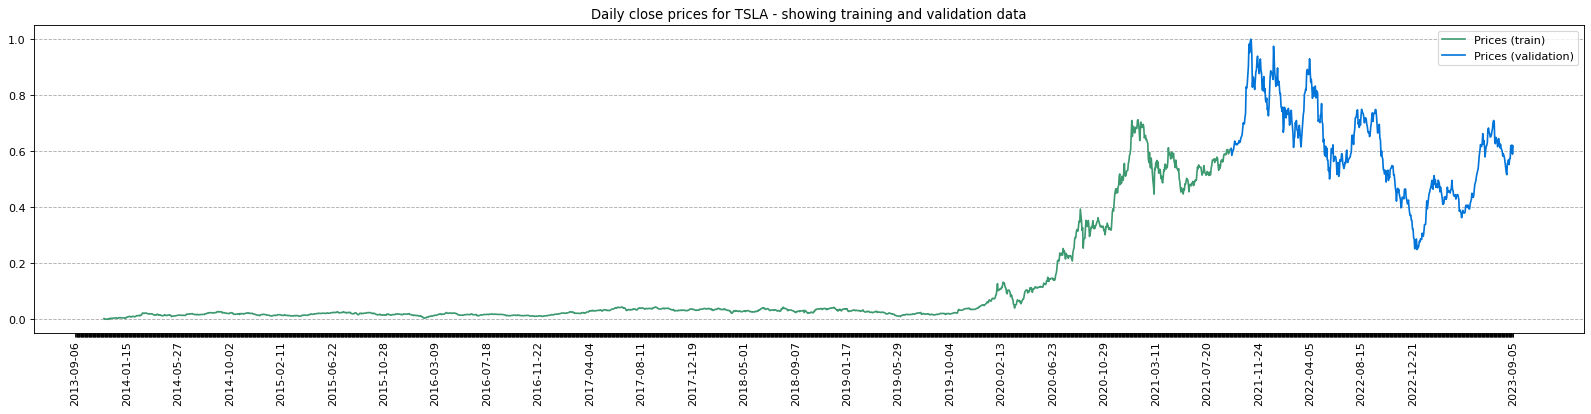

In [52]:
def prepare_data_x(x, window_size):
    # perform windowing
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row,window_size), strides=(x.strides[0],x.strides[0]))
    return output[:-1], output[-1]

def prepare_data_y(x, window_size):
    # # perform simple moving average
    # output = np.convolve(x, np.ones(window_size), 'valid') / window_size

    # use the next day as label
    output = x[window_size:]
    return output

def prepare_data(normalized_data_close_price, config, plot=False):
    data_x, data_x_unseen = prepare_data_x(normalized_data_close_price, window_size=config["data"]["window_size"])
    data_y = prepare_data_y(normalized_data_close_price, window_size=config["data"]["window_size"])

    # split dataset

    split_index = int(data_y.shape[0]*config["data"]["train_split_size"])
    data_x_train = data_x[:split_index]
    data_x_val = data_x[split_index:]
    data_y_train = data_y[:split_index]
    data_y_val = data_y[split_index:]

    if plot:
        # prepare data for plotting

        to_plot_data_y_train = np.zeros(num_data_points)
        to_plot_data_y_val = np.zeros(num_data_points)

        to_plot_data_y_train[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = data_y_train
        to_plot_data_y_val[split_index+config["data"]["window_size"]:] = data_y_val

        to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
        to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)

        ## plots

        fig = figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(data_date, to_plot_data_y_train, label="Prices (train)", color=config["plots"]["color_train"])
        plt.plot(data_date, to_plot_data_y_val, label="Prices (validation)", color=config["plots"]["color_val"])
        xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
        x = np.arange(0,len(xticks))
        plt.xticks(x, xticks, rotation='vertical')
        plt.title("Daily close prices for " + config["y_finance"]["symbol"] + " - showing training and validation data")
        plt.grid(visible=None, which='major', axis='y', linestyle='--')
        plt.legend()
        plt.show()

    return split_index, data_x_train, data_y_train, data_x_val, data_y_val, data_x_unseen

split_index, data_x_train, data_y_train, data_x_val, data_y_val, data_x_unseen = prepare_data(normalized_data_close_price, config, plot=config["plots"]["show_plots"])

In [53]:
data_x_train.shape

(1972, 50)

In [54]:
data_y_train.shape

(1972,)

In [55]:
model = Sequential()
model.add(LSTM(32, input_shape=(config["data"]["window_size"], 1), return_sequences=True)) # Input is shape (5 timesteps x 3 timeseries), output is shape (5 timesteps x 32 variables) because return_sequences  = True
model.add(LSTM(8))  # output is shape (1 timesteps x 8 variables) because return_sequences = False
model.add(Dense(1, activation='linear')) # output is (1 timestep x 1 output unit on dense layer). It is compare to target variable.

In [75]:
data_x_train.shape

(1972, 50)

In [79]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

model.fit(data_x_train,data_y_train,epochs=20)

Epoch 1/20
62/62 [==============================] - 13s 49ms/step - loss: 7.4989e-05 - mean_absolute_error: 0.0045
Epoch 2/20
62/62 [==============================] - 3s 55ms/step - loss: 7.8739e-05 - mean_absolute_error: 0.0050
Epoch 3/20
62/62 [==============================] - 4s 59ms/step - loss: 7.7422e-05 - mean_absolute_error: 0.0051
Epoch 4/20
62/62 [==============================] - 3s 51ms/step - loss: 6.6490e-05 - mean_absolute_error: 0.0045
Epoch 5/20
62/62 [==============================] - 3s 48ms/step - loss: 6.5520e-05 - mean_absolute_error: 0.0041
Epoch 6/20
62/62 [==============================] - 3s 50ms/step - loss: 7.0475e-05 - mean_absolute_error: 0.0046
Epoch 7/20
62/62 [==============================] - 3s 46ms/step - loss: 7.4409e-05 - mean_absolute_error: 0.0045
Epoch 8/20
62/62 [==============================] - 3s 45ms/step - loss: 6.6346e-05 - mean_absolute_error: 0.0041
Epoch 9/20
62/62 [==============================] - 3s 45ms/step - loss: 6.4910e-05 - m

In [80]:
model.evaluate(data_x_val,  data_y_val, verbose=0)

[0.0008220918825827539, 0.021211719140410423]

In [84]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        x = np.expand_dims(x, 2) # in our case, we have only 1 feature, so we need to convert `x` into [batch, sequence, features] for LSTM
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
dataset_val = TimeSeriesDataset(data_x_val, data_y_val)

print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)

NameError: name 'Dataset' is not defined

In [83]:
# here we re-initialize dataloader so the data doesn't shuffled, so we can plot the values by date

# train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=False)
# val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=False)

# model.eval()

# predict on the training data, to see how well the model managed to learn and memorize

predicted_train = np.array([])

for idx, (x, y) in enumerate(data_x_train):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_train = np.concatenate((predicted_train, out))

# predict on the validation data, to see how the model does

predicted_val = np.array([])

for idx, (x, y) in enumerate(data_x_val):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_val = np.concatenate((predicted_val, out))

if config["plots"]["show_plots"]:

    # prepare data for plotting, show predicted prices

    to_plot_data_y_train_pred = np.zeros(num_data_points)
    to_plot_data_y_val_pred = np.zeros(num_data_points)

    to_plot_data_y_train_pred[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(predicted_train)
    to_plot_data_y_val_pred[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(predicted_val)

    to_plot_data_y_train_pred = np.where(to_plot_data_y_train_pred == 0, None, to_plot_data_y_train_pred)
    to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)

    # plots

    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(data_date, data_close_price, label="Actual prices", color=config["plots"]["color_actual"])
    plt.plot(data_date, to_plot_data_y_train_pred, label="Predicted prices (train)", color=config["plots"]["color_pred_train"])
    plt.plot(data_date, to_plot_data_y_val_pred, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
    plt.title("Compare predicted prices to actual prices")
    xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
    x = np.arange(0,len(xticks))
    plt.xticks(x, xticks, rotation='vertical')
    plt.grid(visible=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

    # prepare data for plotting, zoom in validation

    to_plot_data_y_val_subset = scaler.inverse_transform(data_y_val)
    to_plot_predicted_val = scaler.inverse_transform(predicted_val)
    to_plot_data_date = data_date[split_index+config["data"]["window_size"]:]

    # plots

    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(to_plot_data_date, to_plot_data_y_val_subset, label="Actual prices", color=config["plots"]["color_actual"])
    plt.plot(to_plot_data_date, to_plot_predicted_val, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
    plt.title("Zoom in to examine predicted price on validation data portion")
    xticks = [to_plot_data_date[i] if ((i%int(config["plots"]["xticks_interval"]/5)==0 and (len(to_plot_data_date)-i) > config["plots"]["xticks_interval"]/6) or i==len(to_plot_data_date)-1) else None for i in range(len(to_plot_data_date))] # make x ticks nice
    xs = np.arange(0,len(xticks))
    plt.xticks(xs, xticks, rotation='vertical')
    plt.grid(visible=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

ValueError: too many values to unpack (expected 2)

# TEST

In [68]:
df = pd.read_csv('data/TSLA.csv')


df.columns = df.columns.str.lower()
df = df.set_index('date')
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]


In [69]:
train_df

,open,high,low,close,adj close,volume
date,,,,,,
2013-09-05,11.340000,11.433333,11.216667,11.328667,11.328667,100279500
2013-09-06,11.238000,11.313333,11.010000,11.131333,11.131333,129295500
2013-09-09,10.874667,10.966667,10.567333,10.713333,10.713333,215167500
2013-09-10,10.763333,11.166667,10.708667,11.091333,11.091333,134517000
2013-09-11,11.094000,11.193333,10.808667,10.901333,10.901333,87487500
...,...,...,...,...,...,...
2020-08-26,137.333328,144.399994,136.908661,143.544662,143.544662,213591000
2020-08-27,145.363998,153.039993,142.833328,149.250000,149.250000,355395000
2020-08-28,153.007996,154.565994,145.768005,147.559998,147.559998,301218000


In [70]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [71]:
train_df

,open,high,low,close,adj close,volume
date,,,,,,
2013-09-05,-0.597086,-0.596917,-0.597330,-0.595828,-0.595828,-0.211230
2013-09-06,-0.603058,-0.603699,-0.609849,-0.607320,-0.607320,0.129671
2013-09-09,-0.624332,-0.623292,-0.636662,-0.631663,-0.631663,1.138555
2013-09-10,-0.630851,-0.611989,-0.628101,-0.609649,-0.609649,0.191016
2013-09-11,-0.611489,-0.610481,-0.622044,-0.620714,-0.620714,-0.361519
...,...,...,...,...,...,...
2020-08-26,6.780092,6.918038,7.016078,7.103977,7.103977,1.120033
2020-08-27,7.250305,7.406350,7.374947,7.436236,7.436236,2.786046
2020-08-28,7.697877,7.492596,7.552706,7.337816,7.337816,2.149537


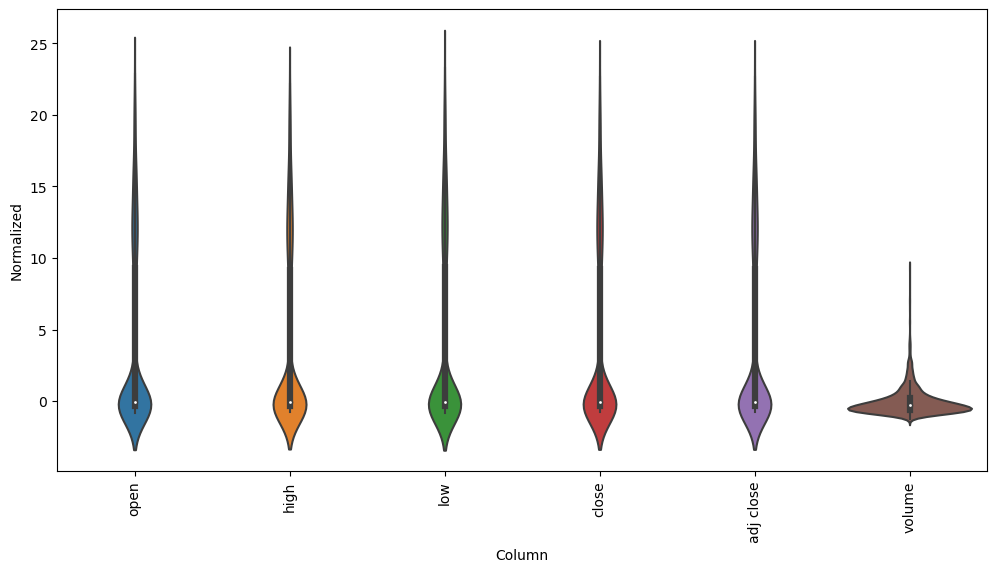

In [73]:
import seaborn as sns

df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [85]:
import yfinance as yf
from datetime import datetime

symbol = "TSLA"

In [86]:

# 1. Getting a stock name
symbol = input("Enter a Stock Price Name: ")

In [87]:
# Get data of 10 recent years
df = yf.download(symbol, period='10y')

[*********************100%%**********************]  1 of 1 completed


In [88]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-09-06,11.238000,11.313333,11.010000,11.131333,11.131333,129295500
2013-09-09,10.874667,10.966667,10.567333,10.713333,10.713333,215167500
2013-09-10,10.763333,11.166667,10.708667,11.091333,11.091333,134517000
2013-09-11,11.094000,11.193333,10.808667,10.901333,10.901333,87487500
2013-09-12,10.933333,11.117333,10.700667,10.995333,10.995333,92400000
...,...,...,...,...,...,...
2023-08-29,238.580002,257.480011,237.770004,257.179993,257.179993,134047600
2023-08-30,254.199997,260.510010,250.589996,256.899994,256.899994,121988400
2023-08-31,255.979996,261.179993,255.050003,258.079987,258.079987,108861700
